# Opti Pipe

In [1]:
from opti_pipe import Model, Floor, Distributor,Node,NodeType, RoomConnection, Graph
from opti_pipe.utils import load_config
from opti_pipe.router import NaiveRouter

Domain language

* inputs are always hot (outputs cooler)

In [2]:
config = load_config()

In [3]:
floor = Floor(config=config,corners=[(0,0),(0,5),(5,5),(5,0)])

distributor = Distributor(config=config,nodes=(
    Node(config,2.0,0,node_type=NodeType.INPUT),
    Node(config,2.2,0,node_type=NodeType.OUTPUT),
    Node(config,2.4,0,node_type=NodeType.INPUT),
    Node(config,2.6,0,node_type=NodeType.OUTPUT),
    Node(config,2.8,0,node_type=NodeType.INPUT),
    Node(config,3.0,0,node_type=NodeType.OUTPUT)),
    heat_per_node=1)

room_connections = (RoomConnection(config,output=Node(config,0,4,node_type=NodeType.OUTPUT),input=Node(config,0,3.75,node_type=NodeType.INPUT),heat_loss=0.8),
                    RoomConnection(config,output=Node(config,5,3,node_type=NodeType.OUTPUT),input=Node(config,5,3.25,node_type=NodeType.INPUT),heat_loss=0.5),
                    RoomConnection(config,output=Node(config,2.6,5,node_type=NodeType.OUTPUT),input=Node(config,2.4,5,node_type=NodeType.INPUT),heat_loss=0.3))


In [4]:
model = Model(
    config = config,
    target_heat_input=100,
    floor=floor,
    distributor=distributor,
    room_connections=room_connections)

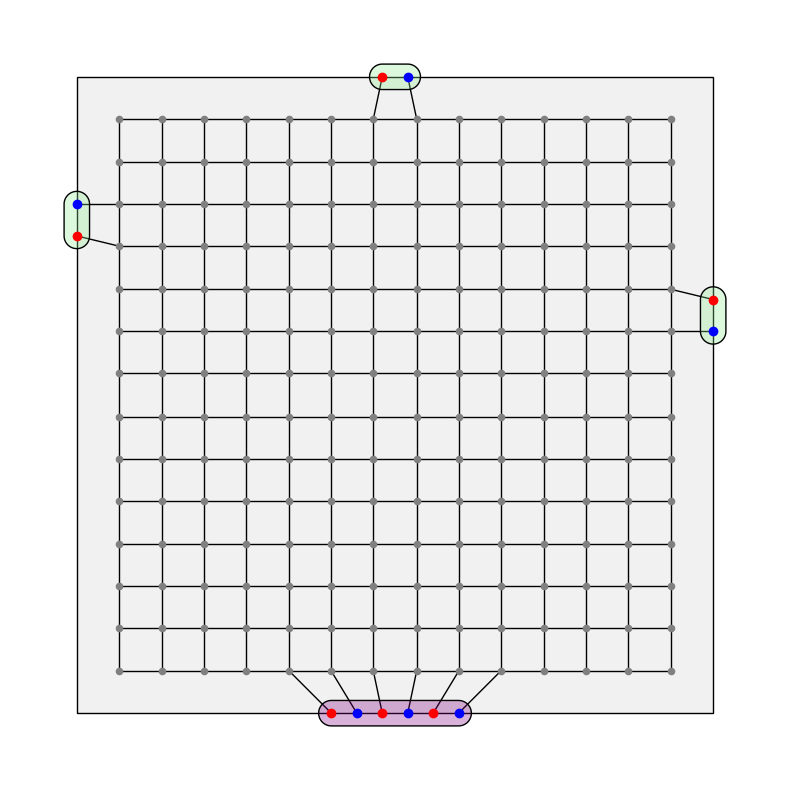

In [5]:

grid_size = 0.3
model.add_graph(grid_size)
model.render(show_graph=True)

Path not found between 2.0_0_NodeType.INPUT and 0_3.75_NodeType.INPUT


(<matplotlib.patches.PathPatch at 0x7f46feeeda60>,
 <matplotlib.lines.Line2D at 0x7f46ff040ce0>)

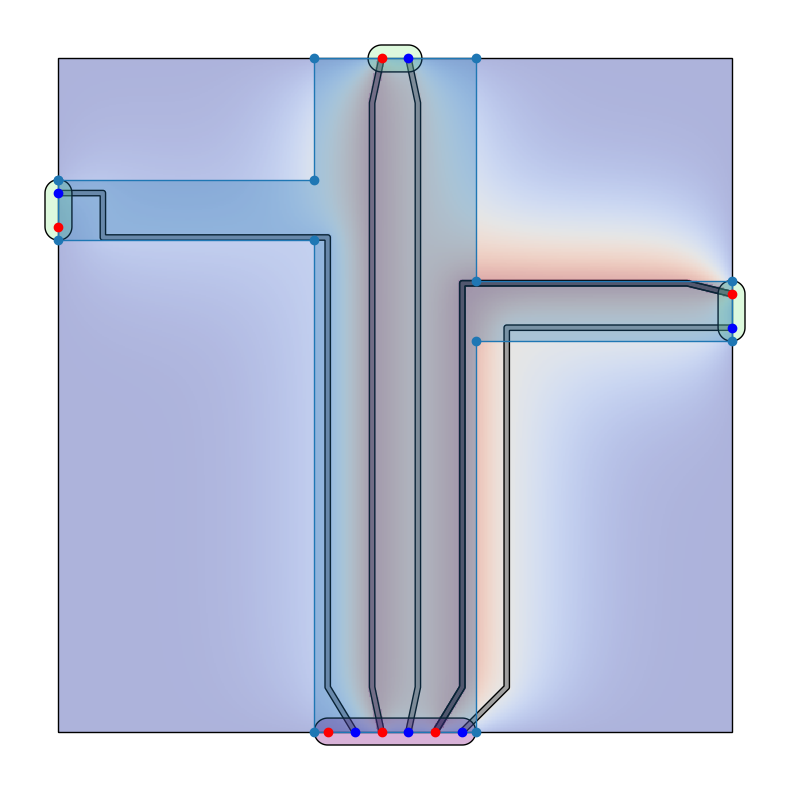

In [6]:
model.pipes = tuple()
router = NaiveRouter(config,model,grid_size)
model = router.route()
model.render(show_graph=False,render_heat_distribution=True)

from opti_pipe.router import Utils
line_string = Utils.get_centerline(model,grid_size)
from shapely.plotting import plot_polygon
plot_polygon(line_string)